# Custom Presumed PDF: log-mean PDF of the scalar dissipation rate

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Building presumed PDF adiabatic and nonadiabatic SFLM libraries for turbulent flows
- Using Spitfire's wrapper around the Python interface of [`TabProps`](https://multiscale.utah.edu/software/) to easily extend tables with clipped Gaussian and Beta PDFs

In this demo, we build reaction models and then incorporate custom built presumed PDF mixing models to perform the convolution integrals outlined in the mixing model documentation.

## Reaction Model

We'll start by building a standard adiabatic SLFM library for an n-heptane/air mixture, except in this case we'll specify a very wide range of the stoichiometric dissipation rate and set `include_extinguished=True` to keep non-burning states after extinction in the library. You can verify this with the plots below, where the discontinuity of extinction is clear.

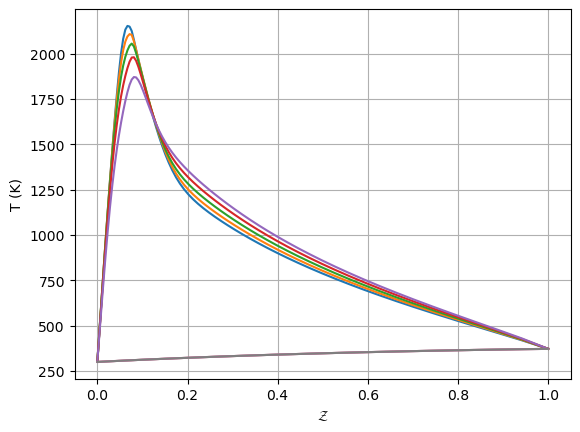

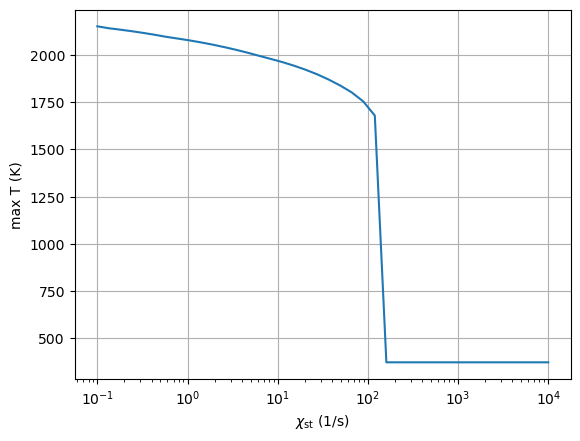

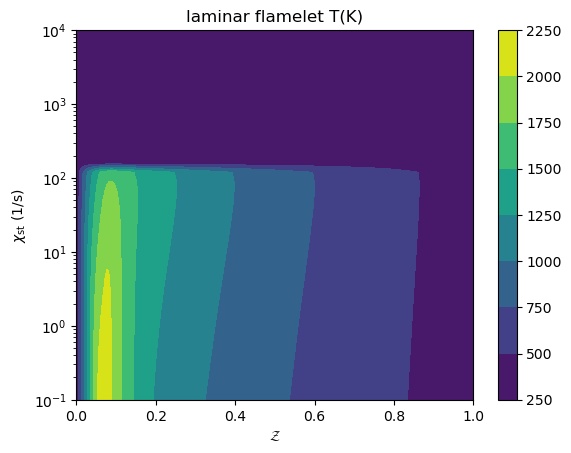

In [1]:
from spitfire import (ChemicalMechanismSpec, 
                      FlameletSpec, 
                      build_adiabatic_slfm_library,
                      apply_mixing_model,
                      PDFSpec,
                      Library)
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

mech = ChemicalMechanismSpec(cantera_input='heptane-liu-hewson-chen-pitsch-highT.yaml', 
                             group_name='gas')

flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='equilibrium',
                              oxy_stream=mech.stream(stp_air=True),
                              fuel_stream=mech.stream('TPY', (372., 101325., 'NXC7H16:1')),
                              grid_points=64)

slfm = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=np.logspace(-1, 4, 40),
                                    diss_rate_ref='stoichiometric',
                                    include_extinguished=True,
                                    verbose=False)

plt.plot(slfm.mixture_fraction_values, slfm['temperature'][:, ::5])
plt.xlabel('$\\mathcal{Z}$')
plt.ylabel('T (K)')
plt.grid()
plt.show()
plt.semilogx(slfm.dissipation_rate_stoich_values, np.max(slfm['temperature'], axis=0), 
             '-', markersize=2)
plt.xlabel('$\\chi_{\\rm st}$ (1/s)')
plt.ylabel('max T (K)')
plt.grid()
plt.show()
plt.contourf(slfm.mixture_fraction_grid, 
             slfm.dissipation_rate_stoich_grid,
             slfm['temperature'])
plt.yscale('log')
plt.xlabel('$\\mathcal{Z}$')
plt.ylabel('$\\chi_{\\rm st}$ (1/s)')
plt.title('laminar flamelet T(K)')
plt.colorbar()
plt.show()

## The User-Defined PDF Class

Here we use a one-parameter logarithmic mean PDF for the dissipation rate (in addition to a clipped Gaussian PDF for the scalar variance). The class below defines several key methods, some of which are required for the integration in Spitfire.

- `set_mean(self, mean)`: necessary API for Spitfire's PDF integration.
- `set_variance(self, variance)`/`set_scalar_variance(self, variance)`: one of these is needed, even though there isn't a variance in this PDF, as Spitfire will internally call one of the two methods depending on which of `variance_values` or `scalar_variance_values` is provided as an argument to `apply_mixing_model`.
- `integrate(self, interpolant)`: necessary for the internal API, which will provide a 1D interpolant with a call operator. The integrand being integrated must be the PDF multiplied by the interpolant. Here we simply use Simpson's rule as the log mean PDF seems pretty simple to integrate. In general, adaptive quadrature should be used to guarantee accurate results.
- `get_pdf(self, x)`: completely unnecessary for integration with the PDF, but convenient for visualization.
- override the `__str__(self)` method as shown for more verbose error messaging.

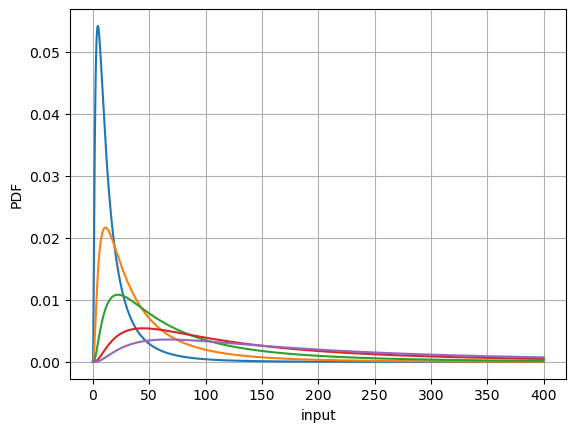

In [2]:
from scipy.integrate import simps as simpson

class LogMean1ParamPDF:
    def __init__(self, sigma):
        self._sigma = sigma
        self._mu = 0.
        self._s2pi = np.sqrt(2. * np.pi)
        self._xt = np.logspace(-6, 6, 1000)
        self._pdft = np.zeros_like(self._xt)

    def __str__(self):
        return f'LogMean1ParamPDF, sigma={self._sigma}'
        
    def get_pdf(self, x):
        s = self._sigma
        m = self._mu
        return 1. / (x * s * self._s2pi) * np.exp(-(np.log(x) - m) * (np.log(x) - m) / (2. * s * s))
    
    def set_mean(self, mean):
        self._mu = np.log(mean) - 0.5 * self._sigma * self._sigma
        self._pdft = self.get_pdf(self._xt)
    
    def set_variance(self, variance):
        pass
    
    def set_scaled_variance(self, variance):
        raise ValueError('cannot use set_scaled_variance on LogMean1ParamPDF, use direct variance values')
    
    def integrate(self, interpolant):
        ig = interpolant(self._xt) * self._pdft
        return simpson(ig, x=self._xt)
    
lm_pdf = LogMean1ParamPDF(1.0)

xtest = np.logspace(-3, np.log10(400), 10000)

for mean in [20., 50., 100.0, 200, 300]:
    lm_pdf.set_mean(mean)
    plt.plot(xtest, lm_pdf.get_pdf(xtest))
plt.grid()
plt.xlabel('input')
plt.ylabel('PDF')
plt.show()

## Integrating the Custom PDF

Now we simply provide our instance of the class, `lm_pdf`, as the `pdf` argument to the `PDFSpec` for `apply_mixing_model`. We just set a single `variance_value` here because we're not actually adding an entire range of variances with the one-parameter log-mean PDF. Also, note that the `set_variance()` method on the class above doesn't actually use the value, which is just set to `1.` for simplicity.

An important consequence of only specifying a single variance or scaled variance value is that the resultant library will be `squeeze`d so that no additional dimensions are actually added. You can see this below when we print the library - it doesn't have a `dissipation_rate_stoich_variance_mean` dimension.

In [3]:
# remove the mass fractions to speed up the convolution integrals - we're only observing the temperature here
mass_fracs = slfm.props
mass_fracs.remove('temperature')
slfm.remove(*mass_fracs)

slfm_t = apply_mixing_model(
    slfm,
    verbose=True,
    mixing_spec={'dissipation_rate_stoich': PDFSpec(pdf=lm_pdf, variance_values=np.array([1.])),
                 'mixture_fraction': PDFSpec(pdf='ClipGauss', scaled_variance_values=np.linspace(0, 1, 8))},
    num_procs=4
    )

print(slfm_t)

dissipation_rate_stoich_variance: computing 2560 integrals... 


/tmp/ipykernel_3916/3178755948.py:31: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simpson(ig, x=self._xt)


completed in 1.3 seconds, average = 1932 integrals/s.
scaled_scalar_variance_mean: computing 20480 integrals... 
completed in 1.4 seconds, average = 14261 integrals/s.

Spitfire Library with 3 dimensions and 1 properties
------------------------------------------
1. Dimension "mixture_fraction_mean" spanning [0.0, 1.0] with 64 points
2. Dimension "dissipation_rate_stoich_mean" spanning [0.09999999999999999, 10000.0] with 40 points
3. Dimension "scaled_scalar_variance_mean" spanning [0.0, 1.0] with 8 points
------------------------------------------
temperature         , min = 299.9999153013872 max = 2144.7073313303486
Extra attributes: {'mech_spec': <spitfire.chemistry.mechanism.ChemicalMechanismSpec object at 0x7f37b6ab5f50>, 'mixing_spec': {'dissipation_rate_stoich': <spitfire.chemistry.tabulation.PDFSpec object at 0x7f37b704f850>, 'mixture_fraction': <spitfire.chemistry.tabulation.PDFSpec object at 0x7f37b7098b50>}}
------------------------------------------



## Visualizing the Result

Now we finish up with some plots. Note especially the effect filtering the dissipation rate has on the max temperature plot - we've actually smoothed the extinction behavior over a much larger range of the mean dissipation rate.

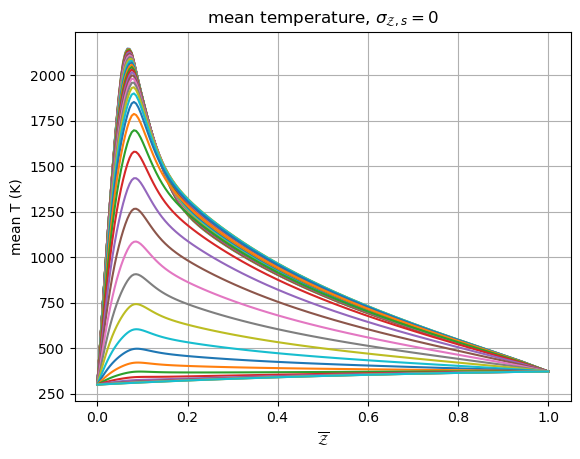

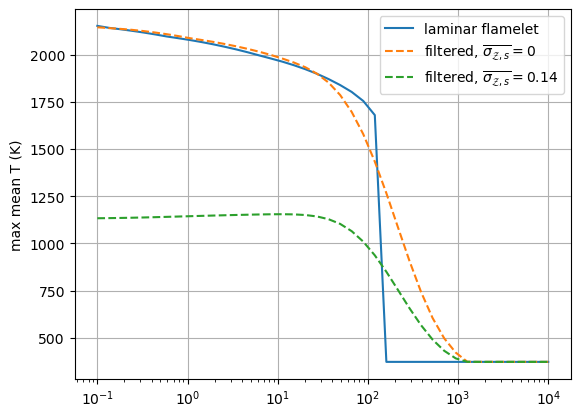

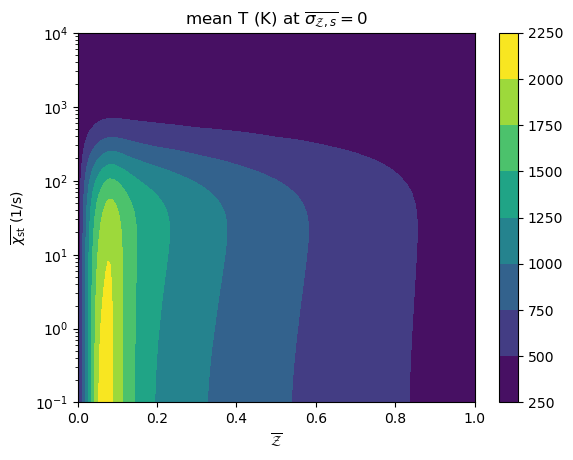

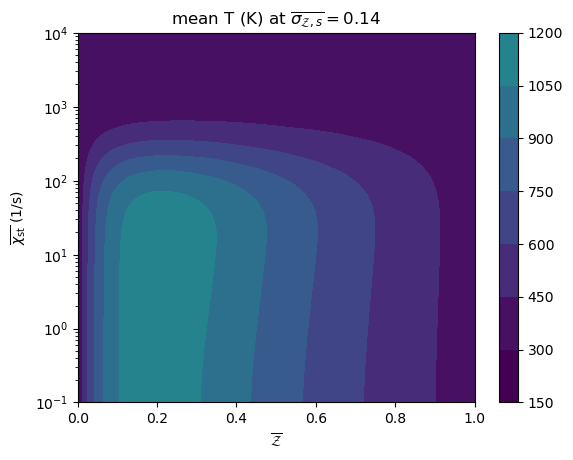

In [4]:
plt.plot(slfm_t.mixture_fraction_mean_values, np.squeeze(slfm_t['temperature'][:, :, 0]))
plt.xlabel('$\\overline{\\mathcal{Z}}$')
plt.ylabel('mean T (K)')
plt.title('mean temperature, $\\sigma_{\\mathcal{Z},s}=0$')
plt.grid()
plt.show()
plt.semilogx(slfm.dissipation_rate_stoich_values, np.max(slfm['temperature'], axis=0), 
             '-', markersize=2, label='laminar flamelet')
plt.semilogx(slfm_t.dissipation_rate_stoich_mean_values, np.max(slfm_t['temperature'], axis=0)[:, 0], 
             '--', markersize=2, label='filtered, $\\overline{\\sigma_{\\mathcal{Z},s}}=0$')
plt.semilogx(slfm_t.dissipation_rate_stoich_mean_values, np.max(slfm_t['temperature'], axis=0)[:, 1], 
             '--', markersize=2, label='filtered, $\\overline{\\sigma_{\\mathcal{Z},s}}=0.14$')
plt.ylabel('$\\overline{\\chi_{\\rm st}}$ (1/s)')
plt.ylabel('max mean T (K)')
plt.grid()
plt.legend()
plt.show()
plt.contourf(np.squeeze(slfm_t.mixture_fraction_mean_grid[:, :, 0]),
             np.squeeze(slfm_t.dissipation_rate_stoich_mean_grid[:, :, 0]),
             np.squeeze(slfm_t['temperature'][:, :, 0]),
             norm=Normalize(slfm_t['temperature'].min(), slfm_t['temperature'].max()))
plt.colorbar()
plt.yscale('log')
plt.xlabel('$\\overline{\\mathcal{Z}}$')
plt.ylabel('$\\overline{\\chi_{\\rm st}}$ (1/s)')
plt.title('mean T (K) at $\\overline{\\sigma_{\\mathcal{Z},s}}=0$')
plt.show()
plt.contourf(np.squeeze(slfm_t.mixture_fraction_mean_grid[:, :, 0]),
             np.squeeze(slfm_t.dissipation_rate_stoich_mean_grid[:, :, 0]),
             np.squeeze(slfm_t['temperature'][:, :, 1]),
             norm=Normalize(slfm_t['temperature'].min(), slfm_t['temperature'].max()))
plt.colorbar()
plt.yscale('log')
plt.xlabel('$\\overline{\\mathcal{Z}}$')
plt.ylabel('$\\overline{\\chi_{\\rm st}}$ (1/s)')
plt.title('mean T (K) at $\\overline{\\sigma_{\\mathcal{Z},s}}=0.14$')
plt.show()

In [5]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import Normalize

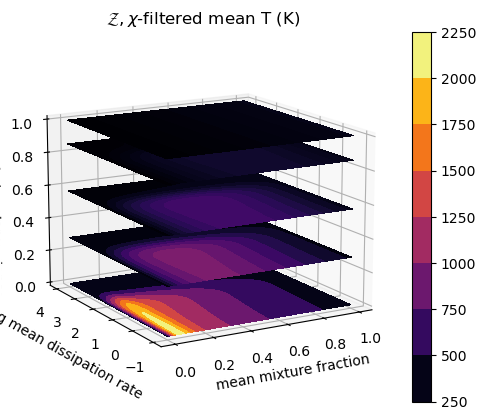

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
z = np.squeeze(slfm_t.mixture_fraction_mean_grid[:, :, 0])
x = np.squeeze(np.log10(slfm_t.dissipation_rate_stoich_mean_grid[:, :, 0]))
v_list = slfm_t.scaled_scalar_variance_mean_values
for idx in [7, 6, 4, 2, 0]:
    p = ax.contourf(z, x, np.squeeze(slfm_t['temperature'][:, :, idx]), 
                    offset=v_list[idx], 
                    cmap='inferno',
                    norm=Normalize(300, 2200))
plt.colorbar(p)
ax.view_init(elev=14, azim=-120)
ax.set_zlim([0, 1])
ax.set_xlabel('mean mixture fraction')
ax.set_ylabel('log mean dissipation rate')
ax.set_zlabel('mean scaled scalar variance')
ax.set_title('$\\mathcal{Z},\chi$-filtered mean T (K)')
plt.show()